In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn import preprocessing

In [2]:
print(tf.__version__)
print(tf.test.is_gpu_available())

2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)#动态分配gpu别让tf一下占满

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
X,Y = fetch_openml('iris',version= 1,return_X_y= True)

In [5]:
type(X)

numpy.ndarray

In [6]:
print("shape of X",X.shape)
print("shape of Y",Y.shape)
print(X[:10])
print(Y[:10])
# 1. sepal length in cm
# 2. sepal width in cm
# 3. petal length in cm
# 4. petal width in cm

shape of X (150, 4)
shape of Y (150,)
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]]
['Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa']


In [7]:
Y = Y.reshape(len(Y),-1)#需要reshape成列向量
enc = preprocessing.OneHotEncoder()
enc.fit(Y)
labels = enc.transform(Y).toarray()#需要三步有点麻烦
print (labels.shape)
print(labels[:10,:])

(150, 3)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [8]:
trainX,testX,trainY,testY = train_test_split(X,labels,train_size = 120,test_size = 30,random_state = 233)

In [9]:
print("shape of trainX",trainX.shape)
print("shape of trainY",trainY.shape)
print(trainX[:20])
print(trainY[:20])

shape of trainX (120, 4)
shape of trainY (120, 3)
[[4.8 3.  1.4 0.3]
 [6.3 3.3 4.7 1.6]
 [6.1 2.8 4.  1.3]
 [5.  2.  3.5 1. ]
 [5.6 2.7 4.2 1.3]
 [5.4 3.7 1.5 0.2]
 [6.7 2.5 5.8 1.8]
 [5.  2.3 3.3 1. ]
 [7.3 2.9 6.3 1.8]
 [7.6 3.  6.6 2.1]
 [6.3 2.7 4.9 1.8]
 [5.  3.3 1.4 0.2]
 [5.8 2.7 3.9 1.2]
 [7.7 2.6 6.9 2.3]
 [4.9 3.1 1.5 0.1]
 [6.1 2.9 4.7 1.4]
 [5.4 3.4 1.7 0.2]
 [6.4 2.8 5.6 2.1]
 [5.1 3.8 1.5 0.3]
 [6.8 3.  5.5 2.1]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [10]:
def MyModel(inputs):
    x = layers.Dense(10,activation="tanh")(inputs)
    x = layers.Dense(8,activation="tanh")(x)
    x = layers.Dense(6,activation="tanh")(x)
    output = layers.Dense(3,activation="softmax")(x)
    model = tf.keras.Model(inputs = inputs,outputs = output)
    model.summary()
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 21        
Total params: 213
Trainable params: 213
Non-trainable params: 0
_________________________________________________________________


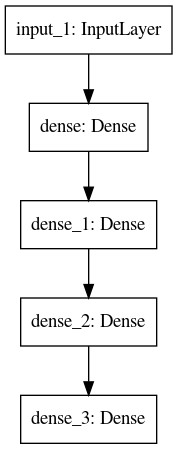

In [11]:
model = MyModel(tf.keras.Input(shape=(4)))
tf.keras.utils.plot_model(model)

In [12]:
adam = tf.keras.optimizers.Adam(lr = 0.04, beta_1=0.9, beta_2=0.999)
sc = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer= adam, loss= sc, metrics=['accuracy','AUC'])

In [13]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             min_delta=1e-2,
                                             patience=5,
                                             verbose=1e-2)]
model.fit(x = trainX,y = trainY, epochs= 150, batch_size = 64, validation_split= 0.2)

Train on 96 samples, validate on 24 samples
Epoch 1/150
96/96 [==============================] - 1s 6ms/sample - loss: 1.1076 - accuracy: 0.3021 - AUC: 0.5337 - val_loss: 1.0936 - val_accuracy: 0.5833 - val_AUC: 0.6059
Epoch 2/150
96/96 [==============================] - 0s 129us/sample - loss: 1.0551 - accuracy: 0.7083 - AUC: 0.7071 - val_loss: 1.0938 - val_accuracy: 0.5000 - val_AUC: 0.5751
Epoch 3/150
96/96 [==============================] - 0s 130us/sample - loss: 1.0157 - accuracy: 0.6771 - AUC: 0.7008 - val_loss: 1.0196 - val_accuracy: 0.5833 - val_AUC: 0.6463
Epoch 4/150
96/96 [==============================] - 0s 121us/sample - loss: 0.9281 - accuracy: 0.7083 - AUC: 0.7595 - val_loss: 0.9667 - val_accuracy: 0.5833 - val_AUC: 0.6936
Epoch 5/150
96/96 [==============================] - 0s 136us/sample - loss: 0.8707 - accuracy: 0.7083 - AUC: 0.8199 - val_loss: 0.9379 - val_accuracy: 0.5833 - val_AUC: 0.8229
Epoch 6/150
96/96 [==============================] - 0s 115us/sample - lo

Epoch 47/150
96/96 [==============================] - 0s 115us/sample - loss: 0.5763 - accuracy: 0.9792 - AUC: 0.9916 - val_loss: 0.5543 - val_accuracy: 1.0000 - val_AUC: 1.0000
Epoch 48/150
96/96 [==============================] - 0s 164us/sample - loss: 0.5895 - accuracy: 0.9583 - AUC: 0.9913 - val_loss: 0.5554 - val_accuracy: 1.0000 - val_AUC: 1.0000
Epoch 49/150
96/96 [==============================] - 0s 122us/sample - loss: 0.5891 - accuracy: 0.9583 - AUC: 0.9912 - val_loss: 0.5918 - val_accuracy: 0.9583 - val_AUC: 0.9991
Epoch 50/150
96/96 [==============================] - 0s 110us/sample - loss: 0.5818 - accuracy: 0.9688 - AUC: 0.9840 - val_loss: 0.5656 - val_accuracy: 1.0000 - val_AUC: 1.0000
Epoch 51/150
96/96 [==============================] - 0s 113us/sample - loss: 0.5755 - accuracy: 0.9792 - AUC: 0.9915 - val_loss: 0.5541 - val_accuracy: 1.0000 - val_AUC: 1.0000
Epoch 52/150
96/96 [==============================] - 0s 109us/sample - loss: 0.5928 - accuracy: 0.9583 - AUC:

96/96 [==============================] - 0s 130us/sample - loss: 0.6233 - accuracy: 0.9271 - AUC: 0.9514 - val_loss: 0.6065 - val_accuracy: 0.9583 - val_AUC: 0.9974
Epoch 94/150
96/96 [==============================] - 0s 121us/sample - loss: 0.5891 - accuracy: 0.9583 - AUC: 0.9914 - val_loss: 0.5561 - val_accuracy: 1.0000 - val_AUC: 1.0000
Epoch 95/150
96/96 [==============================] - 0s 124us/sample - loss: 0.6023 - accuracy: 0.9479 - AUC: 0.9976 - val_loss: 0.5684 - val_accuracy: 1.0000 - val_AUC: 1.0000
Epoch 96/150
96/96 [==============================] - 0s 124us/sample - loss: 0.6013 - accuracy: 0.9375 - AUC: 0.9899 - val_loss: 0.5593 - val_accuracy: 1.0000 - val_AUC: 1.0000
Epoch 97/150
96/96 [==============================] - 0s 137us/sample - loss: 0.5873 - accuracy: 0.9688 - AUC: 0.9837 - val_loss: 0.6747 - val_accuracy: 0.8750 - val_AUC: 0.9557
Epoch 98/150
96/96 [==============================] - 0s 137us/sample - loss: 0.6031 - accuracy: 0.9479 - AUC: 0.9752 - val

Epoch 139/150
96/96 [==============================] - 0s 108us/sample - loss: 0.5925 - accuracy: 0.9583 - AUC: 0.9833 - val_loss: 0.5561 - val_accuracy: 1.0000 - val_AUC: 1.0000
Epoch 140/150
96/96 [==============================] - 0s 132us/sample - loss: 0.5744 - accuracy: 0.9792 - AUC: 0.9842 - val_loss: 0.6550 - val_accuracy: 0.9167 - val_AUC: 0.9323
Epoch 141/150
96/96 [==============================] - 0s 119us/sample - loss: 0.6025 - accuracy: 0.9479 - AUC: 0.9756 - val_loss: 0.6107 - val_accuracy: 0.9167 - val_AUC: 0.9965
Epoch 142/150
96/96 [==============================] - 0s 111us/sample - loss: 0.5830 - accuracy: 0.9688 - AUC: 0.9842 - val_loss: 0.5520 - val_accuracy: 1.0000 - val_AUC: 1.0000
Epoch 143/150
96/96 [==============================] - 0s 117us/sample - loss: 0.5888 - accuracy: 0.9583 - AUC: 0.9836 - val_loss: 0.6044 - val_accuracy: 0.9583 - val_AUC: 0.9974
Epoch 144/150
96/96 [==============================] - 0s 114us/sample - loss: 0.6211 - accuracy: 0.9271 

In [14]:
y_pred = model.predict(testX)
y_test_class = np.argmax(testY,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         9

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

[[ 9  0  0]
 [ 0 12  0]
 [ 0  0  9]]
